[Reference](https://towardsdatascience.com/introduction-to-hierarchical-time-series-forecasting-part-ii-e73dfd3de86b)

In [2]:
pip install scikit-hts

     |████████████████████████████████| 9.5 MB 31.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [4]:
# load the data 
df = pd.read_csv("https://raw.githubusercontent.com/erykml/medium_articles/master/data/tourism.csv") \
       .drop(columns=["Unnamed: 0"])

# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

In [5]:
# inspect all the regions per state
df.groupby("state")["region"].apply(set).to_frame()

,region
state,
ACT,{Canberra}
NSW,"{Snowy_Mountains, Outback_NSW, Blue_Mountains,..."
NT,"{Hobart_and_the_South, North_West, MacDonnell,..."
QLD,"{Central_Queensland, Darling_Downs, Bundaberg,..."
SA,"{Fleurieu_Peninsula, Adelaide_Hills, Adelaide,..."
VIC,"{Central_Highlands, Melbourne, Ballarat, High_..."
WA,"{Australias_North_West, Australias_Coral_Coast..."


In [6]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")

Number of time series at the bottom level: 77
Number of time series at the middle level: 7


In [7]:
states = df["state"].unique()
regions = df["state_region"].unique()

total = {'total': list(states)}
state = {k: [v for v in regions if v.startswith(k)] for k in states}
hierarchy = {**total, **state}

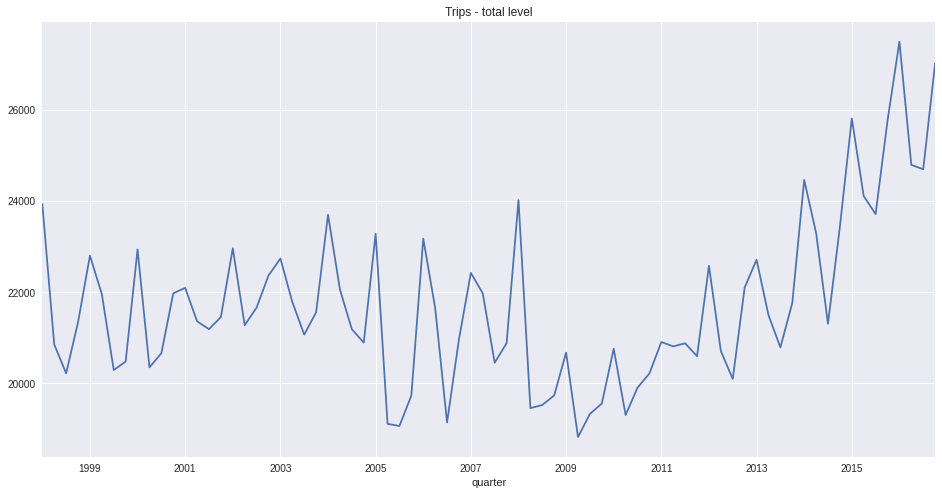

In [8]:
hierarchy_df["total"].plot(title="Trips - total level");

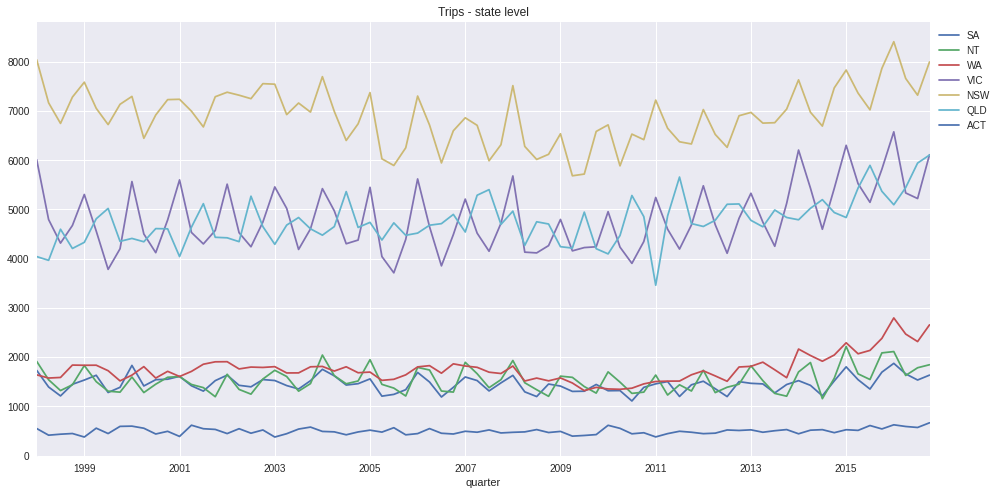

In [9]:
ax = hierarchy_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

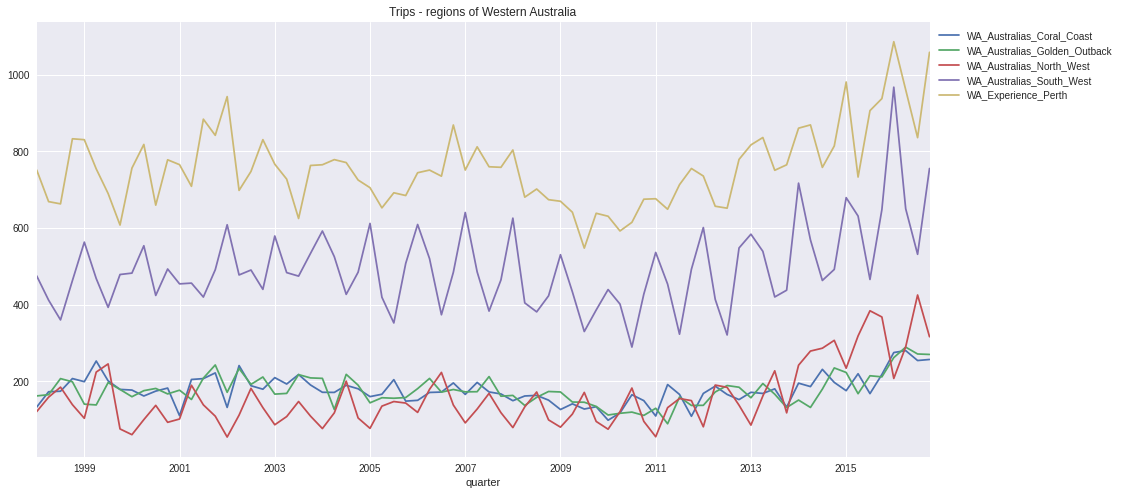

In [10]:
ax = hierarchy_df[hierarchy['WA']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));

# Hierarchical time series forecasting

In [14]:
model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=4)

In [16]:
model_td_arima = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
model_td_arima = model_td_arima.fit(hierarchy_df, hierarchy)
pred_td_arima = model_td_arima.predict(steps_ahead=4)

In [17]:
model_ols_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model_ols_arima = model_ols_arima.fit(hierarchy_df, hierarchy)
pred_ols_arima = model_ols_arima.predict(steps_ahead=4)